In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [2]:
EXPERIMENT_NAME = 'P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'

In [3]:
extracted_features_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/P3856/summarised-results/extracted-features-YHE211_1.pkl')

In [4]:
extracted_features_df[(extracted_features_df.isotope_idx_not_in_saturation == 4)].sample(n=3)

,sequence,charge,file_idx,peak_idx,target_coords,theoretical_mz,q_value,delta_mz_ppm,delta_rt,delta_scan,...,monoisotopic_mz_delta_ppm,number_of_isotopes,peak_proportion_intensity,peak_proportions,rt_apex,scan_apex,run_name,run_group,short_run_name,human
20042,TTGIVMDSGDGVTHTVPIYEGYALPHAILR,3,29,0,"{""mono_mz"": 1061.8763085650646, ""scan_apex"": 1...",1061.876276,0.000004,-0.070295,-0.000048,0.045931,...,-0.070295,7,37280,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",2002.403237,130,P3856_YHE211_1_Slot1-1_1_5104,YHE211,YHE211_1,1
16661,Q[-17.0265]TIDNSQGAYQEAFDISK,2,29,0,"{""mono_mz"": 999.4583419406152, ""scan_apex"": 26...",999.457976,0.000006,0.589710,-0.002484,-0.009159,...,0.589710,7,512695,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1839.929500,258,P3856_YHE211_1_Slot1-1_1_5104,YHE211,YHE211_1,1
12994,LVSSPCCIVTSTYGWTANMER,2,29,0,"{""mono_mz"": 1216.5563435607473, ""scan_apex"": 8...",1216.555790,0.000004,-1.873783,-0.001901,-0.101580,...,-1.873783,7,116574,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",2035.739294,75,P3856_YHE211_1_Slot1-1_1_5104,YHE211,YHE211_1,1


In [5]:
selected_sequence = 'MSVQPTVSLGGFEITPPVVLR'
selected_sequence_charge = 2

In [6]:
selected_sequence_df = extracted_features_df[(extracted_features_df.sequence == selected_sequence) & (extracted_features_df.charge == selected_sequence_charge)].iloc[0]

In [7]:
isotope_intensities_l = json.loads(selected_sequence_df.isotope_intensities_l)

In [8]:
isotope_intensities_df = pd.DataFrame(isotope_intensities_l, columns=['summed_intensity','saturated','inferred_intensity','inferred','isotope_points','isotope_apex_points'])


In [9]:
isotope_intensities_df['mz'] = isotope_intensities_df.apply(lambda row: row.isotope_points[0][0], axis=1)

In [10]:
isotope_intensities_df

,summed_intensity,saturated,inferred_intensity,inferred,isotope_points,isotope_apex_points,mz
0,31095.0,True,46069.0,True,"[[1114.107927490229, 59.0, 19997.0, 2220.44705...","[[1114.1131622404166, 92.0, 19962.0, 2216.7417...",1114.107927
1,35970.0,True,55466.0,True,"[[1114.6105109176456, 61.0, 19997.0, 2220.4470...","[[1114.610511007979, 85.0, 19962.0, 2216.74177...",1114.610511
2,26028.0,True,36074.0,True,"[[1115.1132076808312, 76.0, 19997.0, 2220.4470...","[[1115.1132077712061, 89.0, 19962.0, 2216.7417...",1115.113208
3,16015.0,True,16615.0,True,"[[1115.6160177797894, 72.0, 19997.0, 2220.4470...","[[1115.6160178702046, 78.0, 19962.0, 2216.7417...",1115.616018
4,6021.0,False,6021.0,False,"[[1116.113701844599, 76.0, 19997.0, 2220.44705...","[[1116.1137019350545, 80.0, 19962.0, 2216.7417...",1116.113702
5,2395.0,False,2395.0,False,"[[1116.61673743452, 75.0, 19997.0, 2220.447052...","[[1116.616737525016, 75.0, 19962.0, 2216.74177...",1116.616737
6,752.0,False,752.0,False,"[[1117.1198863602135, 96.0, 19997.0, 2220.4470...","[[1117.119886450751, 68.0, 19962.0, 2216.74177...",1117.119886


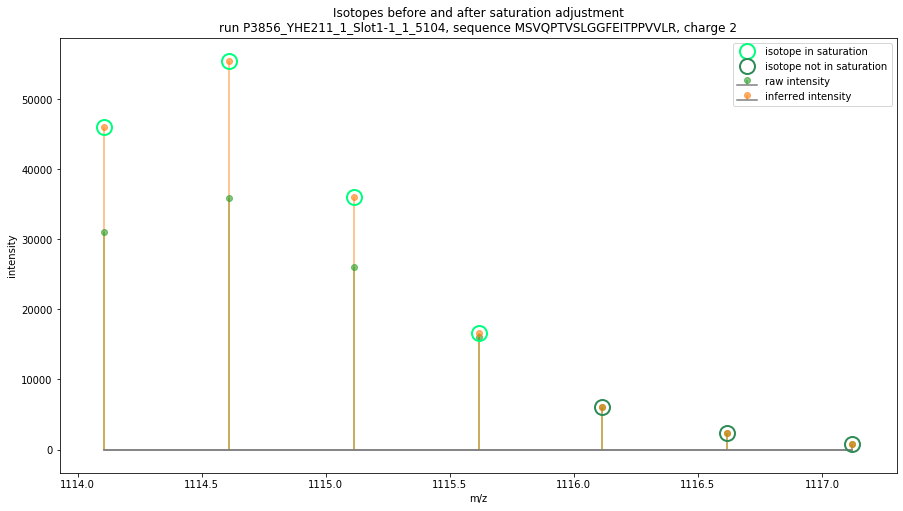

In [11]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(isotope_intensities_df.mz, isotope_intensities_df.summed_intensity, use_line_collection=True, label='raw intensity')
plt.setp(markerline, 'color', 'tab:green')
plt.setp(stemlines, 'color', 'tab:green')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

markerline, stemlines, baseline = ax.stem(isotope_intensities_df.mz, isotope_intensities_df.inferred_intensity, use_line_collection=True, label='inferred intensity')
plt.setp(markerline, 'color', 'tab:orange')
plt.setp(stemlines, 'color', 'tab:orange')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

# highlight the isotopes with inferred intensity
adjusted_intensity_df = isotope_intensities_df[(isotope_intensities_df.inferred == True)]
ax.plot(adjusted_intensity_df.mz, adjusted_intensity_df.inferred_intensity, marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15, label='isotope in saturation')

# highlight the isotopes without inferred intensity
not_adjusted_intensity_df = isotope_intensities_df[(isotope_intensities_df.inferred == False)]
ax.plot(not_adjusted_intensity_df.mz, not_adjusted_intensity_df.inferred_intensity, marker='o', markerfacecolor='none', markeredgecolor='seagreen', linestyle='', markeredgewidth=2, ms=15, label='isotope not in saturation')

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)
plt.legend(loc='best')
plt.title('Isotopes before and after saturation adjustment\nrun {}, sequence {}, charge {}'.format(RUN_NAME, selected_sequence, selected_sequence_charge))
plt.show()

#### distribution of isotopes in saturation

In [12]:
df = extracted_features_df[(extracted_features_df.isotope_idx_not_in_saturation > 0)]

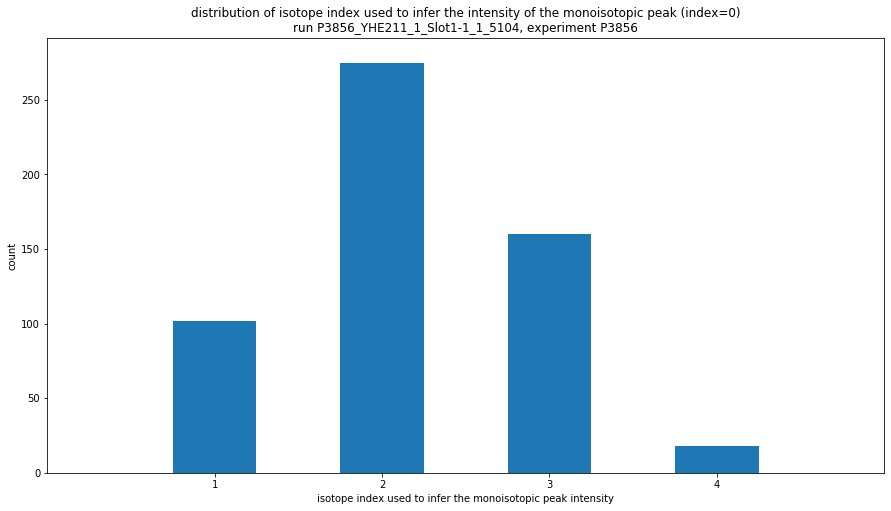

In [23]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

counts = np.bincount(df.isotope_idx_not_in_saturation)
ax1.bar(range(df.isotope_idx_not_in_saturation.max()+1), counts, width=0.5, align='center')
ax1.set(xticks=range(1,df.isotope_idx_not_in_saturation.max()+1), xlim=[0, df.isotope_idx_not_in_saturation.max()+1])

plt.xlabel('isotope index used to infer the monoisotopic peak intensity')
plt.ylabel('count')
plt.title('distribution of isotope index used to infer the intensity of the monoisotopic peak (index=0)\nrun {}, experiment {}'.format(RUN_NAME, EXPERIMENT_NAME))

plt.show()